# Generalization

## Setup device

In [36]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

In [37]:
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

batch_size = 32
# Original dataset (ISIC)
original_dataset = datasets.ImageFolder(root='/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test', transform=transform) 
original_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False) 

# HAM10000 dataset
test_dataset = datasets.ImageFolder(root='/kaggle/input/melanoma/DermMel/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Map classes to match original dataset
test_dataset.classes = ['melanoma' if 'Melanoma' else 'benign' for cls in test_dataset.classes]
test_dataset.class_to_idx = {cls: idx for idx, cls in enumerate(test_dataset.classes)}

## Load models

In [38]:
def load_model(path):
    model = torch.load(path, map_location=device)
    model.to(device)
    model.eval()
    return model

alexnet = load_model('/kaggle/input/alexnet/pytorch/default/1/alexnet.pt')
alexnet_aug = load_model('/kaggle/input/augmented_alexnet/pytorch/default/1/augmented_alexnet.pt')
resnet = load_model('/kaggle/input/resnet/pytorch/default/1/resnet.pt')
resnet_aug = load_model('/kaggle/input/augmented_resnet/pytorch/default/1/augmented_resnet.pt')
densenet = load_model('/kaggle/input/densenet/pytorch/default/1/densenet.pt')
densenet_aug = load_model('/kaggle/input/augmented_densenet/pytorch/default/1/augmented_densenet.pt')

/tmp/ipykernel_31/3205378875.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)


## Evaluate

In [39]:
import numpy as np

def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:,1]
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

### AlexNet

In [40]:
labels_alexnet, preds_alexnet, probs_alexnet = evaluate_model(alexnet, test_loader)
labels_augalexnet, preds_augalexnet, probs_augalexnet = evaluate_model(alexnet_aug, test_loader)

### ResNet

In [41]:
labels_resnet, preds_resnet, probs_resnet = evaluate_model(resnet, test_loader)
labels_augresnet, preds_augresnet, probs_augresnet = evaluate_model(resnet_aug, test_loader)

### DenseNet

In [42]:
labels_densenet, preds_densenet, probs_densenet = evaluate_model(densenet, test_loader)
labels_augdensenet, preds_augdensenet, probs_augdensenet = evaluate_model(densenet_aug, test_loader)

## Results

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def print_metrics(labels, preds, probs, model_name="Model"):
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    auc = roc_auc_score(labels, probs)

    # Metrics
    print(f"Results for {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, probs)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

### DenseNet

Results for ResNet
Accuracy: 0.3808
Precision: 0.3865
Recall: 0.4067
F1 Score: 0.3964
AUC: 0.3557



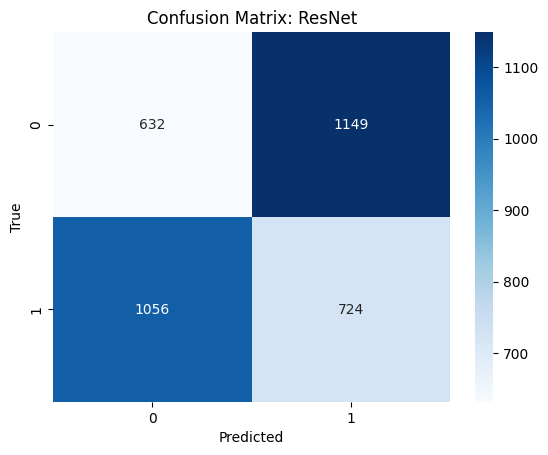

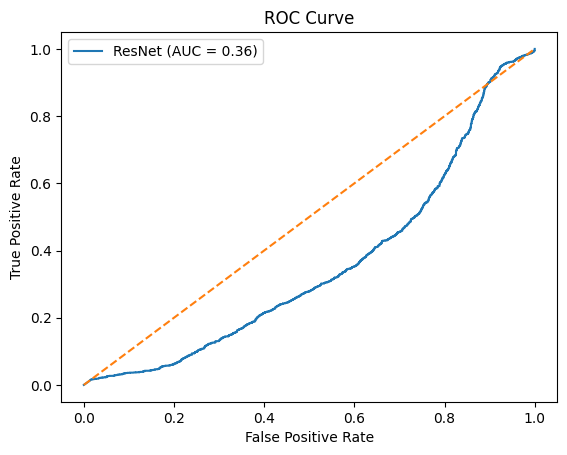

Results for Augmented ResNet
Accuracy: 0.4322
Precision: 0.3612
Recall: 0.1770
F1 Score: 0.2376
AUC: 0.4406



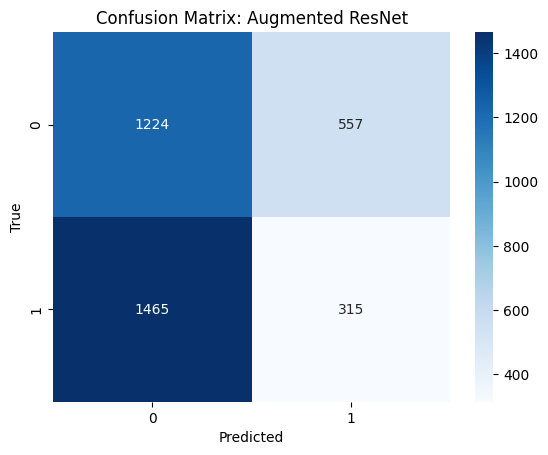

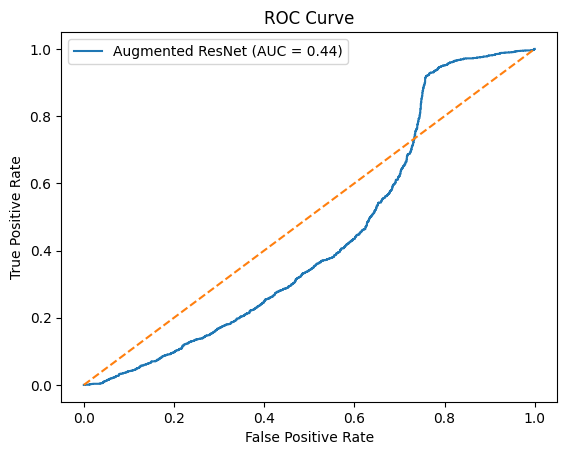

In [44]:
print_metrics(labels_resnet, preds_resnet, probs_resnet, model_name="ResNet")
print_metrics(labels_augresnet, preds_augresnet, probs_augresnet, model_name="Augmented ResNet")

### AlexNet

Results for AlexNet
Accuracy: 0.3499
Precision: 0.3918
Recall: 0.5444
F1 Score: 0.4557
AUC: 0.3086



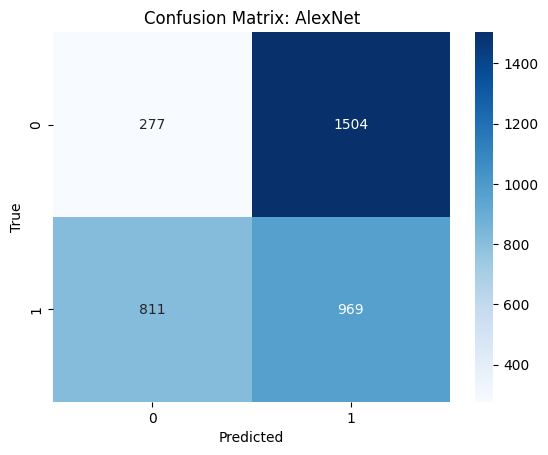

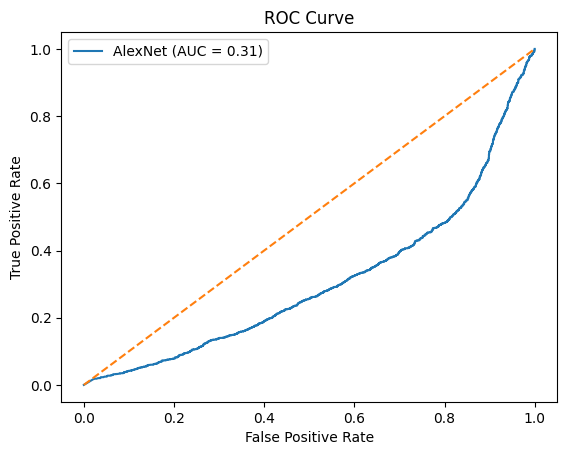

Results for Augmented AlexNet
Accuracy: 0.4676
Precision: 0.3324
Recall: 0.0646
F1 Score: 0.1082
AUC: 0.3872



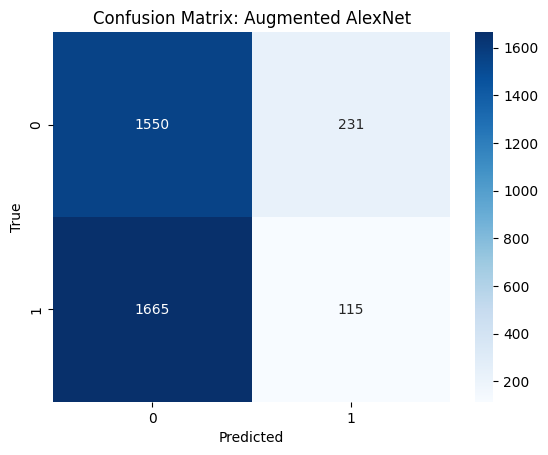

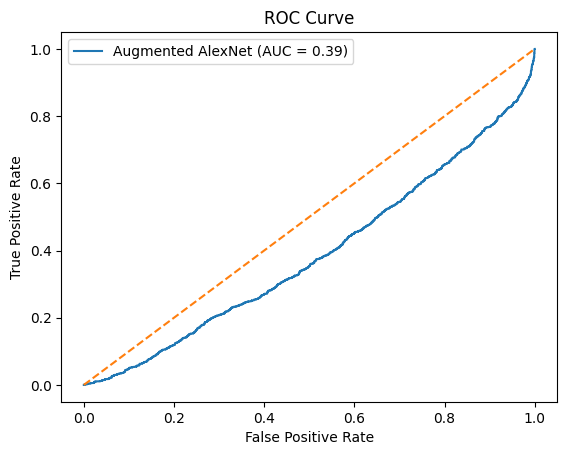

In [45]:
print_metrics(labels_alexnet, preds_alexnet, probs_alexnet, model_name="AlexNet")
print_metrics(labels_augalexnet, preds_augalexnet, probs_augalexnet, model_name="Augmented AlexNet")

### DenseNet

Results for DenseNet
Accuracy: 0.3092
Precision: 0.3625
Recall: 0.5034
F1 Score: 0.4214
AUC: 0.2133



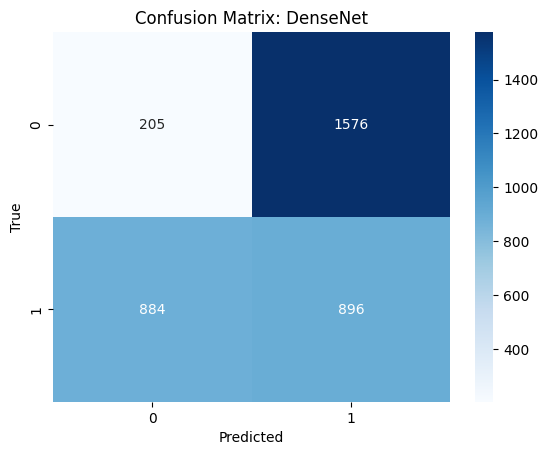

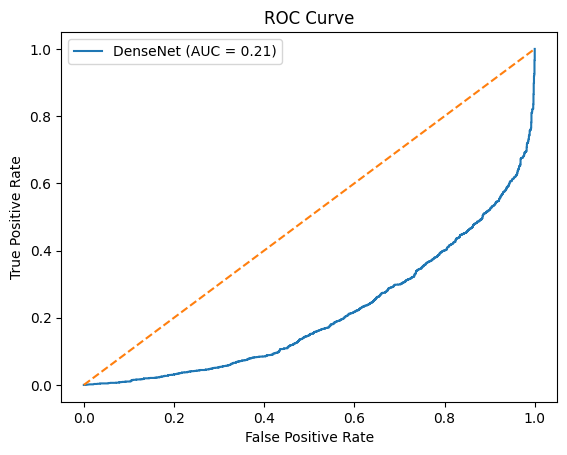

Results for Augmented DenseNet
Accuracy: 0.4381
Precision: 0.3497
Recall: 0.1444
F1 Score: 0.2044
AUC: 0.3542



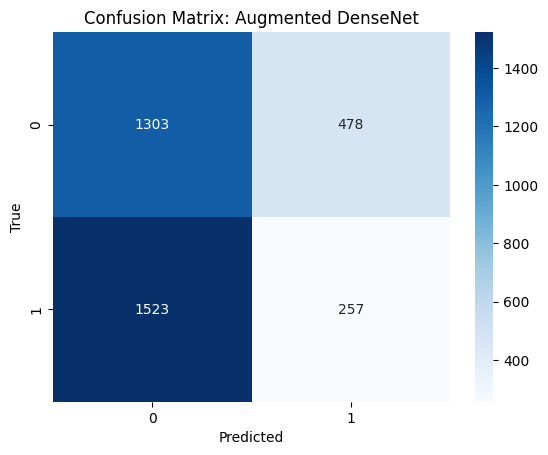

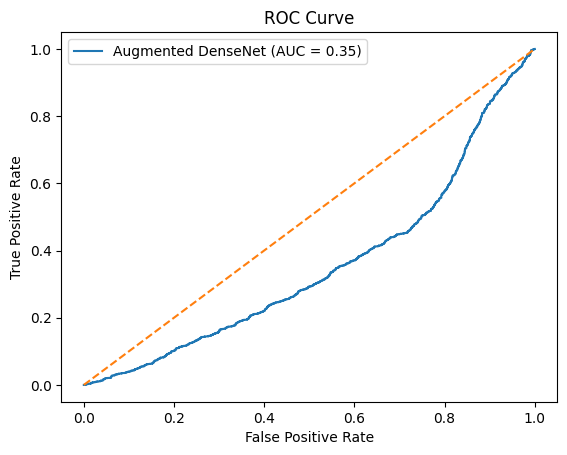

In [46]:
print_metrics(labels_densenet, preds_densenet, probs_densenet, model_name="DenseNet")
print_metrics(labels_augdensenet, preds_augdensenet, probs_augdensenet, model_name="Augmented DenseNet")